<a href="https://colab.research.google.com/github/LimYooyeol/AI-Paper-Code/blob/main/ResNet/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/My Drive/Paper Implementation/'

%cd $BASE

%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Paper Implementation


'/content/drive/My Drive/Paper Implementation'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import os

## Prepare Data (CIFAR 10)

### load data

In [4]:
DATAPATH = BASE + 'datasets'
if not os.path.exists(DATAPATH):
  os.mkdir(DATAPATH)

# set device
if torch.cuda.is_available() :
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])


# load data
train_data = dset.CIFAR10('./datasets', train = True, download = True, transform = transform)
loader_train = DataLoader(train_data, batch_size = 32, shuffle= True) # no validation set

test_data = dset.CIFAR10('./datasets', train = False, download = True, transform= transform)
loader_test = DataLoader(test_data, batch_size = 32, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


### show an image

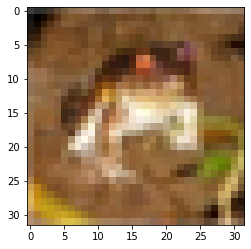

6


'frog'

In [5]:
import matplotlib.pyplot as plt

_, label = train_data[0]
img = train_data.data[0]
plt.imshow(img)
plt.show()
print(label)
train_data.classes[label]

## Define Training Loop

Referenced a lot from cs231n/assignment2 a lot for this part
(# https://cs231n.github.io/assignments2021/assignment2/)

### Calculate Accuracy

In [31]:
def check_accuracy(data_loader, model, verbose = True) :

  if verbose :
    if data_loader.dataset.train :
      print('Train set accurcy')
    else :
      print('Test set accuracy')

  num_correct = 0
  num_total = 0
  model.eval() # evaluation mode

  with torch.no_grad() :
    for x, y in data_loader :
      x = x.to(device = device)
      y = y.to(device = device)

      scores = model(x)

      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_total += preds.size(0)
    
    acc = float(num_correct) / num_total
    if verbose :
      print('Correct : (%d / %d), Accuracy : (%.2f)' % (num_correct, num_total, 100*acc))

  return 100*acc

### Training Loop

In [35]:
def train(model, optimizer, data_loader, epochs = 1, verbose = True):
  model = model.to(device = device)

  log = {'loss' : [], 'acc' : []}

  for e in range(epochs):
    if verbose : 
      print('epochs : %d / %d' % (e, epochs))
    log['acc'].append(check_accuracy(loader_test, model, verbose = verbose))
    
    for t, (x, y) in enumerate(data_loader) :
      model.train() # training mode
      x = x.to(device = device)
      y = y.to(device = device)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()


      if t % 100 == 0 :
        log['loss'].append(loss)
        if verbose :
          print('iteration %d, loss = %.4f' % (t, loss.item()))
  
  return log

## Modules

### Flatten

In [8]:
def flatten(x) :
  N = x.shape[0]
  return x.view(N, -1)

class Flatten(nn.Module) :
  def forward(self,x ):
    return flatten(x)

### Plain-Net

In [9]:
# Conv-BN-ReLU
class ConvReLU(nn.Module) :
  def __init__(self, in_channel, out_channel, stride = 1, padding = 1) :
    super().__init__()

    self.conv = nn.Conv2d(in_channel, out_channel, kernel_size = 3, stride = stride, padding = padding, bias = False)
    self.BN = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU()

  def forward(self, x) :
    x = self.conv(x)
    x = self.BN(x)
    x = self.relu(x)

    return x

In [10]:
# Block consists of 2*n ConvReLU modules
class Feature_Block_Plain(nn.Module) :
  def __init__(self, in_channel, out_channel, n, feature_reduce = False) :
    super().__init__()

    self.n = n

    if feature_reduce : 
      stride = 2
    else :
      stride = 1

    layers = [ConvReLU(in_channel, out_channel, stride = stride, padding = 1)]

    for i in range(0, 2*n - 1):
      layers.append( ConvReLU(out_channel, out_channel, padding = 1))
    
    self.layers = nn.ModuleList(layers)

  def forward(self, x) :
    for i in range(0, 2*self.n) :
      x = self.layers[i](x)

    return x


In [11]:
# Plain Net
class Plain_Net(nn.Module) :
  def __init__(self, n) :
    super().__init__()

    self.init_layer = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    
    self.FB1 = Feature_Block_Plain(16, 16, n)
    self.FB2 = Feature_Block_Plain(16, 32, n, feature_reduce = True)
    self.FB3 = Feature_Block_Plain(32, 64, n, feature_reduce = True)

    self.FC = nn.Sequential(
        nn.AvgPool2d(kernel_size = 2, stride = 2),
        Flatten(),
        nn.Linear(4*4*64, 10)
    )

  def forward(self, x):
    x = self.init_layer(x)
    x = self.FB3(self.FB2(self.FB1(x)))
    x = self.FC(x)

    return x


### ResNet

In [12]:
# Basic residual block consists of pair of convolution layer
class Residual_Block(nn.Module) :
  def __init__(self, in_channel, out_channel, feature_reduce = False) :
    super().__init__()

    self.feature_reduce = feature_reduce

    if feature_reduce :
      stride = 2
    else : 
      stride = 1

    self.Conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size = 3, stride = stride, padding = 1, bias = False), 
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),
        nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1, bias =  False),
        nn.BatchNorm2d(out_channel)
    )

    if feature_reduce :
      self.shortcut = nn.Sequential(
          # reduce feature map by pooling (No more parameters, option (A))
          nn.MaxPool2d(kernel_size = 2, stride = 2)
      )
    else :
      self.shortcut = nn.Identity()

  def forward(self, x) :
    x_prev = self.shortcut(x)
    
    if self.feature_reduce :
      # zero padding for dimension matching
      concat = torch.zeros_like(x_prev)
      x_prev = torch.concat((x_prev, concat), axis = 1)
    else :
      x_prev = x_prev

    F_x = self.Conv(x)

    return F.relu(F_x + x_prev)


In [13]:
# Block consists of n residual blocks
class Feature_Block(nn.Module) :
  def __init__(self, in_channel, out_channel, n, feature_reduce = False) :
    super().__init__()
    self.n = n

    residual_blocks = [Residual_Block(in_channel, out_channel, feature_reduce = feature_reduce)]

    for i in range(0, n-1) :
      residual_blocks.append(Residual_Block(out_channel, out_channel))
    
    self.residual_blocks = nn.ModuleList(residual_blocks)

  def forward(self, x) :
    for i in range(0, self.n) :
      x = self.residual_blocks[i](x)

    return x      

In [14]:
# ResNet
class ResNet(nn.Module) :
  def __init__(self, n) :
    super().__init__()

    self.init_layer = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 3, padding = 1, bias = False),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )

    self.Feature_Block1 = Feature_Block(16, 16, n)

    self.Feature_Block2 = Feature_Block(16, 32, n, feature_reduce = True)

    self.Feature_Block3 = Feature_Block(32, 64, n, feature_reduce = True)

    self.FC = nn.Sequential(
        nn.AvgPool2d(kernel_size = 2, stride = 2),
        Flatten(),
        nn.Linear(4*4*64, 10)
    )

  def forward(self, x) :
    x = self.init_layer(x)
    x = self.Feature_Block1(x)
    x = self.Feature_Block2(x)
    x = self.Feature_Block3(x)
    x = self.FC(x)

    return x

## Train

In [15]:
def plot_loss(loss, label) :
  plt.xlabel('iterations(1e2)')
  plt.ylabel('training loss')

  plt.plot(loss, label = label)
  plt.legend()

In [16]:
def plot_acc(acc, label) :
  plt.xlabel('epochs')
  plt.ylabel('accuracy(test data)')

  plt.plot(acc, label = label)
  plt.legend()

### Plain-Net

In [25]:
learning_rate = 5e-3

plain = Plain_Net(5)
optimizer_plain = optim.SGD(plain.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)

In [26]:
train_log_plain = train(plain, optimizer_plain, loader_train, epochs = 25, verbose = True)

epochs : 0 / 25
Test set accuracy
Correct : (1000 / 10000), Accuracy : (10.00)
iteration 0, loss = 2.2997
iteration 100, loss = 2.1085
iteration 200, loss = 1.9418
iteration 300, loss = 2.1252
iteration 400, loss = 1.9445
iteration 500, loss = 1.7257
iteration 600, loss = 1.7416
iteration 700, loss = 1.9898
iteration 800, loss = 1.6339
iteration 900, loss = 1.8304
iteration 1000, loss = 1.5380
iteration 1100, loss = 1.7312
iteration 1200, loss = 1.8437
iteration 1300, loss = 1.7910
iteration 1400, loss = 1.4318
iteration 1500, loss = 1.7857
epochs : 1 / 25
Test set accuracy
Correct : (3970 / 10000), Accuracy : (39.70)
iteration 0, loss = 1.5008
iteration 100, loss = 1.3940
iteration 200, loss = 1.8897
iteration 300, loss = 1.8657
iteration 400, loss = 1.5764
iteration 500, loss = 1.7326
iteration 600, loss = 1.7629
iteration 700, loss = 1.7251
iteration 800, loss = 1.8061
iteration 900, loss = 1.4476
iteration 1000, loss = 1.6424
iteration 1100, loss = 1.2815
iteration 1200, loss = 1.5

### ResNet

In [23]:
learning_rate = 5e-3

resnet = ResNet(5)
optimizer_resnet = optim.SGD(resnet.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)

In [36]:
train_log_resnet =  train(resnet, optimizer_resnet, loader_train, epochs = 20, verbose = False)

### Visualize

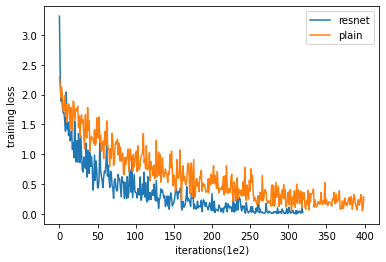

In [37]:
plot_loss(train_log_resnet['loss'], 'resnet')
plot_loss(train_log_plain['loss'], 'plain')

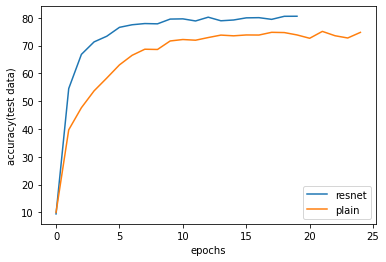

In [38]:
plot_acc(train_log_resnet['acc'], 'resnet')
plot_acc(train_log_plain['acc'], 'plain')